Connected to database successfully
Movie table has columns: ['awards', 'cast', 'critic_score', 'director', 'genre_ids', 'metacritic_url', 'movie_id', 'rating', 'release_date', 'release_year', 'runtime', 'studio', 'summary', 'title', 'title_normalized', 'user_score']
Box office table has columns: ['domestic_box_office', 'international_box_office', 'movie_id', 'opening_weekend', 'performance_id', 'production_budget', 'theatre_count', 'worldwide_box_office']

Running query to get movie data...
Loaded 3660 movies with complete financial and theatre data

First 5 rows of our data:
                   title  year       genre  production_budget  \
0              Antitrust  2001    33,31,11         30000000.0   
1     A Walk to Remember  2002       26,11         11000000.0   
2              Mad Money  2008   26,33,9,7         22000000.0   
3     Over Her Dead Body  2008     26,14,7         10000000.0   
4  The Other Boleyn Girl  2008  5,26,16,11         40000000.0   

   worldwide_box_office  t

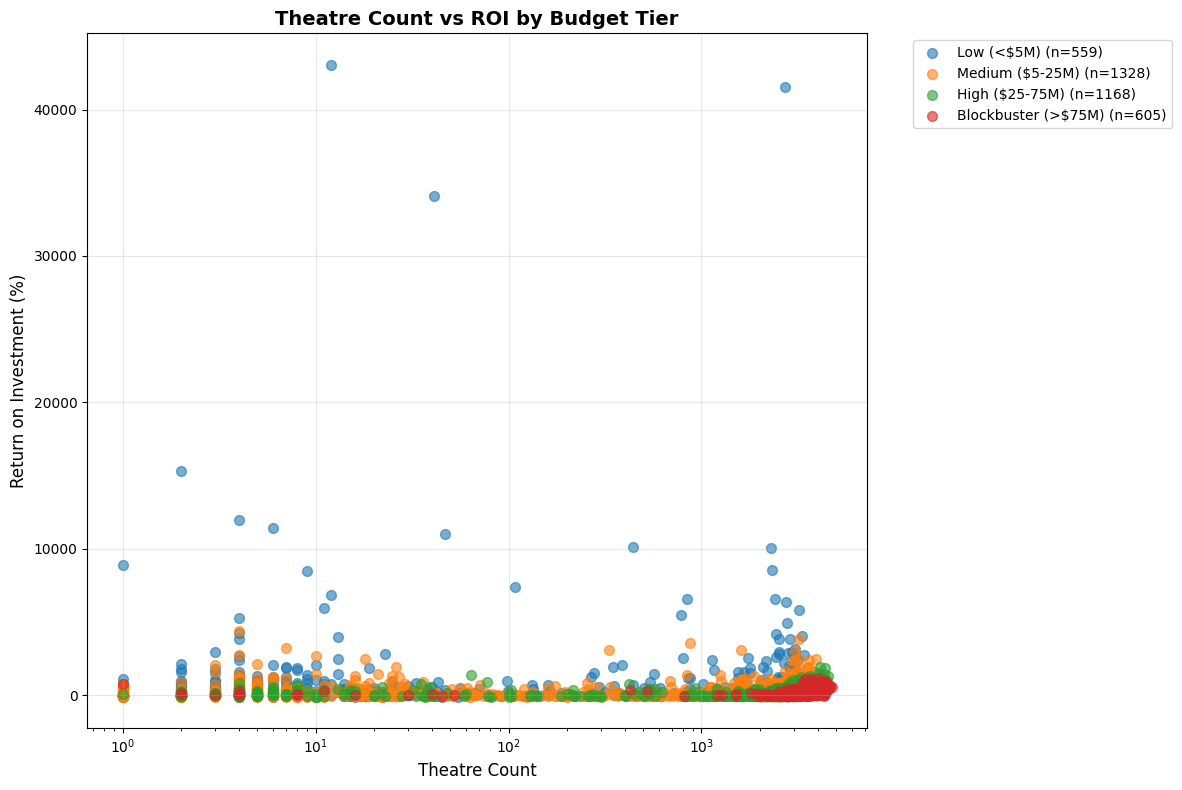


KEY INSIGHTS AND BUSINESS IMPLICATIONS
• Strongest theatre-ROI relationship: Blockbuster (>$75M)
  Correlation: 0.355
  Business implication: Theatre expansion has biggest ROI impact for Blockbuster (>$75M) films

• Highest average ROI: Low (<$5M)
  Average ROI: 932.7%
  Business implication: Low (<$5M) films offer best return on investment

• Widest average releases: Blockbuster (>$75M)
  Average theatres: 3466
  Business implication: Blockbuster (>$75M) films require massive distribution

• Theatre deployment efficiency by tier:
  Low (<$5M): 218.3 ROI points per 100 theatres
  Medium ($5-25M): 17.5 ROI points per 100 theatres
  High ($25-75M): 6.1 ROI points per 100 theatres
  Blockbuster (>$75M): 5.8 ROI points per 100 theatres

• Statistical reliability:
  Statistically significant results: ['Low (<$5M)', 'Medium ($5-25M)', 'High ($25-75M)', 'Blockbuster (>$75M)']
  These tiers show reliable theatre-ROI relationships (p < 0.05)

IMPORTANT LIMITATIONS
• Sample size: Analysis inclu

In [8]:
# =============================================================================
# MOVIE THEATRE COUNT vs ROI ANALYSIS
# =============================================================================
# RESEARCH QUESTION: How does theatre count (market penetration) affect return 
# on investment, and how does this relationship vary across different budget levels?
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sqlalchemy import create_engine

# =============================================================================
# STEP 1: CONNECT TO THE DATABASE
# =============================================================================

connection_string = 'postgresql://admin@localhost:5432/moviedb'

# create_engine creates a connection object that we can use to run SQL queries
engine = create_engine(connection_string)
print("Connected to database successfully")

# =============================================================================
# STEP 2: DISCOVER WHAT COLUMNS EXIST IN OUR TABLES
# =============================================================================
# Check what columns are available in the movie and box_office_performance tables
# I used to get errors on the table names, so I query information_schema first

check_columns_query = """
SELECT table_name, column_name, data_type 
FROM information_schema.columns 
WHERE table_name IN ('movie', 'box_office_performance')
ORDER BY table_name, column_name
"""

# pd.read_sql_query runs our SQL and returns the results as a pandas DataFrame
table_info = pd.read_sql_query(check_columns_query, engine)

# Filter the results to get column names for each table separately
# .tolist() converts pandas data to a regular Python list
movie_columns = table_info[table_info['table_name'] == 'movie']['column_name'].tolist()
box_office_columns = table_info[table_info['table_name'] == 'box_office_performance']['column_name'].tolist()

print(f"Movie table has columns: {movie_columns}")
print(f"Box office table has columns: {box_office_columns}")

# =============================================================================
# STEP 3: BUILD OUR DATA QUERY 
# =============================================================================
# We want to get movie information + financial data, but we need to check
# what columns actually exist first (column names might vary)

# Start with an empty list to store the columns we want to select
movie_info_columns = []

# Check if 'title' column exists and add it if it does
# The 'm.' prefix means "from the movie table" (m is our table alias)
if 'title' in movie_columns:
    movie_info_columns.append('m.title')

# Check for year information - might be called 'release_year' or 'year'
# We use 'as year' to rename 'release_year' to 'year' for consistency    
if 'release_year' in movie_columns:
    movie_info_columns.append('m.release_year as year')
elif 'year' in movie_columns:
    movie_info_columns.append('m.year')

# Check for genre information - might be stored as 'genre' or 'genre_ids'
if 'genre' in movie_columns:
    movie_info_columns.append('m.genre')
elif 'genre_ids' in movie_columns:
    movie_info_columns.append('m.genre_ids as genre')

# Build the final SQL query using the columns we found
# f-string allows us to insert Python variables into the SQL string
# JOIN connects the movie table (m) with box_office_performance table (bp)
# WHERE filters out movies with missing or zero values (can't calculate ROI with zeros)
query = f"""
SELECT 
    {', '.join(movie_info_columns)},
    bp.production_budget,
    bp.worldwide_box_office,
    bp.theatre_count
FROM movie m
JOIN box_office_performance bp ON m.movie_id = bp.movie_id
WHERE bp.theatre_count > 0 
AND bp.production_budget > 0
AND bp.worldwide_box_office > 0
"""

print(f"\nRunning query to get movie data...")

# =============================================================================
# STEP 4: LOAD THE DATA FROM DATABASE
# =============================================================================
# Execute our SQL query and load the results into a pandas DataFrame
# This is like importing data from the database into a Python spreadsheet
data = pd.read_sql_query(query, engine)
print(f"Loaded {len(data)} movies with complete financial and theatre data")

# Let's look at the first few rows to see what our data looks like
print("\nFirst 5 rows of our data:")
print(data.head())

# =============================================================================
# STEP 5: CALCULATE RETURN ON INVESTMENT (ROI)
# =============================================================================
# ROI is a key business metric that shows how profitable an investment was
# Formula: ROI = (Revenue - Cost) / Cost * 100
# Example: If a movie cost $10M and made $30M:
#   ROI = (30M - 10M) / 10M * 100 = 200%
# Higher ROI = better financial performance

# Calculate ROI for each movie and add it as a new column
data['roi'] = ((data['worldwide_box_office'] - data['production_budget']) / data['production_budget']) * 100

print(f"\nROI calculation complete. ROI ranges from {data['roi'].min():.1f}% to {data['roi'].max():.1f}%")

# =============================================================================
# STEP 6: CREATE BUDGET CATEGORIES FOR ANALYSIS
# =============================================================================
# Movies have very different budgets ($1K to $400M+)
# We group them into categories to see if patterns differ by budget level
# pd.cut() automatically sorts movies into bins based on their budget

# Define budget ranges (bins) and labels for each category
budget_bins = [0, 5_000_000, 25_000_000, 75_000_000, float('inf')]
budget_labels = ['Low (<$5M)', 'Medium ($5-25M)', 'High ($25-75M)', 'Blockbuster (>$75M)']

# pd.cut assigns each movie to a budget tier based on its production_budget
data['budget_tier'] = pd.cut(
    data['production_budget'],
    bins=budget_bins,
    labels=budget_labels
)

# Show how many movies are in each budget tier
print("\nBudget tier distribution:")
print(data['budget_tier'].value_counts())

# =============================================================================
# STEP 7: CALCULATE OVERALL CORRELATION
# =============================================================================
# Correlation measures how two variables move together
# Values range from -1 to +1:
#   +1 = perfect positive relationship (as X increases, Y always increases)
#    0 = no relationship (X and Y are independent)
#   -1 = perfect negative relationship (as X increases, Y always decreases)
# 
# We want to know: do movies with more theatres tend to have higher ROI?

# stats.pearsonr calculates Pearson correlation coefficient
# It returns two values: correlation coefficient (r) and p-value (significance)
overall_correlation = stats.pearsonr(data['theatre_count'], data['roi'])

print(f"\nOverall correlation between theatre count and ROI: {overall_correlation[0]:.3f}")
print(f"Statistical significance: p = {overall_correlation[1]:.4f}")

# Interpret the correlation strength
correlation_value = abs(overall_correlation[0])
if correlation_value < 0.1:
    strength = "negligible"
elif correlation_value < 0.3:
    strength = "weak"
elif correlation_value < 0.5:
    strength = "moderate"
elif correlation_value < 0.7:
    strength = "strong"
else:
    strength = "very strong"

print(f"This indicates a {strength} relationship between theatre count and ROI")

# =============================================================================
# STEP 8: ANALYZE EACH BUDGET TIER SEPARATELY
# =============================================================================
# The overall correlation might hide different patterns within budget tiers
# For example: maybe blockbusters show strong correlation but low-budget films don't
# We'll calculate correlation for each budget tier separately

print("\nDetailed Analysis by Budget Tier:")
print("-" * 50)

# Dictionary to store results for each tier (we'll use this later for insights)
tier_results = {}

# Loop through each budget category
for tier in data['budget_tier'].cat.categories:
    # Filter data to only include movies from this budget tier
    tier_data = data[data['budget_tier'] == tier]
    
    # Only analyze tiers with enough movies for reliable statistical results
    # We need at least 10 movies to trust correlation calculations
    if len(tier_data) >= 10:
        # Calculate correlation for this specific budget tier
        correlation = stats.pearsonr(tier_data['theatre_count'], tier_data['roi'])
        
        # Store results in our dictionary for later analysis
        tier_results[tier] = {
            'correlation': correlation[0],
            'p_value': correlation[1],
            'sample_size': len(tier_data),
            'average_roi': tier_data['roi'].mean(),
            'average_theatres': tier_data['theatre_count'].mean(),
            'median_roi': tier_data['roi'].median(),
            'median_theatres': tier_data['theatre_count'].median()
        }
        
        # Print detailed results for this tier
        print(f"\n{tier}:")
        print(f"  Correlation: {correlation[0]:.3f} (p = {correlation[1]:.4f})")
        print(f"  Average ROI: {tier_data['roi'].mean():.1f}%")
        print(f"  Average Theatres: {tier_data['theatre_count'].mean():.0f}")
        print(f"  Sample Size: {len(tier_data)} movies")
        
        # Interpret correlation strength for this tier
        tier_strength = abs(correlation[0])
        if tier_strength < 0.1:
            tier_interpretation = "negligible"
        elif tier_strength < 0.3:
            tier_interpretation = "weak"
        elif tier_strength < 0.5:
            tier_interpretation = "moderate"
        else:
            tier_interpretation = "strong"
        print(f"  Relationship strength: {tier_interpretation}")
    
    else:
        print(f"\n{tier}: Not enough data ({len(tier_data)} movies) for reliable analysis")

# =============================================================================
# STEP 9: CREATE VISUALIZATION
# =============================================================================
# A scatter plot will show the relationship visually
# Each point represents one movie: X = theatre count, Y = ROI
# Different colors represent different budget tiers

print("\nCreating visualization...")

# Create a new figure (graph) with specified size
plt.figure(figsize=(12, 8))

# Define colors for each budget tier (blue, orange, green, red)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each budget tier separately with different colors
for i, tier in enumerate(data['budget_tier'].cat.categories):
    # Get data for just this budget tier
    tier_data = data[data['budget_tier'] == tier]
    
    # Only plot if we have data for this tier
    if len(tier_data) > 0:
        # Create scatter plot: X = theatre_count, Y = roi
        # alpha=0.6 makes points semi-transparent (helps with overlapping)
        # s=50 sets the size of each point
        plt.scatter(tier_data['theatre_count'], tier_data['roi'], 
                   color=colors[i], 
                   label=f'{tier} (n={len(tier_data)})', 
                   alpha=0.6, 
                   s=50)

# Format the plot to make it readable
plt.xlabel('Theatre Count', fontsize=12)
plt.ylabel('Return on Investment (%)', fontsize=12)
plt.title('Theatre Count vs ROI by Budget Tier', fontsize=14, fontweight='bold')

# Use logarithmic scale for X-axis because theatre counts vary widely
# (some movies have 1 theatre, others have 4000+)
plt.xscale('log')

# Add legend to show what each color means
# bbox_to_anchor places legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid to make it easier to read values
plt.grid(True, alpha=0.3)

# Adjust layout so legend doesn't get cut off
plt.tight_layout()

# Display the plot
plt.show()

# =============================================================================
# STEP 10: GENERATE KEY BUSINESS INSIGHTS
# =============================================================================
# Now we analyze our results to extract actionable business insights
# This is where we turn numbers into business recommendations

print("\n" + "="*60)
print("KEY INSIGHTS AND BUSINESS IMPLICATIONS")
print("="*60)

# Only generate insights if we have results to work with
if tier_results:
    
    # INSIGHT 1: Which budget tier shows strongest theatre-ROI relationship?
    # max() finds the tier with highest correlation value
    # key= tells max() what to compare (absolute correlation values)
    strongest_tier = max(tier_results.keys(), 
                        key=lambda x: abs(tier_results[x]['correlation']))
    strongest_correlation = tier_results[strongest_tier]['correlation']
    print(f"• Strongest theatre-ROI relationship: {strongest_tier}")
    print(f"  Correlation: {strongest_correlation:.3f}")
    print(f"  Business implication: Theatre expansion has biggest ROI impact for {strongest_tier} films")
    
    # INSIGHT 2: Which budget tier has highest average ROI?
    highest_roi_tier = max(tier_results.keys(),
                          key=lambda x: tier_results[x]['average_roi'])
    highest_roi = tier_results[highest_roi_tier]['average_roi']
    print(f"\n• Highest average ROI: {highest_roi_tier}")
    print(f"  Average ROI: {highest_roi:.1f}%")
    print(f"  Business implication: {highest_roi_tier} films offer best return on investment")
    
    # INSIGHT 3: Which budget tier uses most theatres on average?
    widest_release_tier = max(tier_results.keys(),
                             key=lambda x: tier_results[x]['average_theatres'])
    most_theatres = tier_results[widest_release_tier]['average_theatres']
    print(f"\n• Widest average releases: {widest_release_tier}")
    print(f"  Average theatres: {most_theatres:.0f}")
    print(f"  Business implication: {widest_release_tier} films require massive distribution")
    
    # INSIGHT 4: Compare efficiency across tiers
    print(f"\n• Theatre deployment efficiency by tier:")
    for tier, results in tier_results.items():
        efficiency = results['average_roi'] / results['average_theatres'] * 100
        print(f"  {tier}: {efficiency:.1f} ROI points per 100 theatres")
    
    # INSIGHT 5: Statistical significance check
    print(f"\n• Statistical reliability:")
    reliable_results = [tier for tier, results in tier_results.items() 
                       if results['p_value'] < 0.05]
    print(f"  Statistically significant results: {reliable_results}")
    print(f"  These tiers show reliable theatre-ROI relationships (p < 0.05)")

# =============================================================================
# STEP 11: IMPORTANT LIMITATIONS AND CAVEATS
# =============================================================================
# Every analysis has limitations - it's important to acknowledge them
# This helps users understand when/how to apply these insights

print(f"\n" + "="*60)
print("IMPORTANT LIMITATIONS")
print("="*60)
print(f"• Sample size: Analysis includes {len(data)} movies with complete data")
print(f"• Selection bias: Results may favor studio-distributed films")
print(f"• Missing data: Movies without complete financial data are excluded")
print(f"• Time period: Results may vary across different release years")
print(f"• Geographic scope: Analysis may be limited to specific markets")
print(f"• Causation vs correlation: Theatre count may not CAUSE higher ROI")
print(f"• Industry changes: Streaming and COVID may have changed patterns")

print(f"\n" + "="*60)
print("RECOMMENDED APPLICATIONS")
print("="*60)
print(f"• Best for: Studio films with traditional theatrical releases")
print(f"• Use with caution: Independent films, festival releases, limited runs")
print(f"• Consider: Genre-specific patterns may differ from overall trends")
print(f"• Update regularly: Movie industry patterns change over time")

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Successfully analyzed {len(data)} movies across {len(tier_results)} budget tiers")
print(f"Data loaded from database: {connection_string}")
print(f"Results show varying theatre-ROI relationships by budget level")